# From Words to Vectors: Understanding Text Embeddings

**Yale AI Research Techniques Workshop**  
*Text Embeddings and Classification for Entity Resolution*

## Learning Objectives
- Understand how text embeddings encode semantic meaning in vector space
- Experience the classic Word2Vec model and its mathematical relationships
- Learn modern tokenization approaches with tiktoken
- Apply concepts to library metadata entity resolution challenges

---

## Introduction: The Vector Space Revolution

Imagine if we could capture the meaning of words as points in space, where words with similar meanings cluster together. This is exactly what text embeddings accomplish. Today we'll start with the foundational Word2Vec model and work our way up to modern approaches.

**Key Insight**: Words that appear in similar contexts tend to have similar meanings. Word2Vec learns these relationships by analyzing vast amounts of text and encoding semantic relationships as mathematical operations in vector space.

## Part 1: Setting Up Word2Vec

We'll use the NeuML Word2Vec model, which provides the classic Google Word2Vec vectors in an easy-to-use format. This model was trained on billions of words from Google News and captures fascinating semantic relationships.

In [1]:
# Install required packages
!pip install staticvectors tiktoken numpy matplotlib pandas seaborn scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from staticvectors import StaticVectors
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load the Word2Vec model
# This downloads the pre-trained Google News Word2Vec vectors
print("Loading Word2Vec model... (this may take a minute on first run)")
model = StaticVectors("neuml/word2vec")
print(f"Model loaded! Vocabulary size: {len(model.vocab) if hasattr(model, 'vocab') else 'Unknown'}")
print(f"Vector dimensions: {model.embeddings(['word'])[0].shape[0]}")

Loading Word2Vec model... (this may take a minute on first run)
Model loaded! Vocabulary size: Unknown
Vector dimensions: 300


## Part 2: The Magic of Word Arithmetic

Word2Vec's most famous property is that semantic relationships become mathematical operations. Let's explore the classic example: **king - man + woman ≈ queen**

In [4]:
def get_word_vector(word):
    """Get the vector representation of a word."""
    try:
        vector = model.embeddings([word])[0]
        return vector
    except:
        print(f"Warning: '{word}' not found in vocabulary")
        return None

def find_similar_words(vector, exclude_words=None, top_k=5):
    """Find words most similar to a given vector."""
    if exclude_words is None:
        exclude_words = []
    
    # Get all word vectors (this is a simplified approach)
    # In practice, you'd use the model's built-in similarity search
    test_words = ['queen', 'princess', 'duchess', 'empress', 'lady', 'woman', 'female',
                  'king', 'prince', 'duke', 'emperor', 'lord', 'man', 'male',
                  'royal', 'nobility', 'monarch', 'ruler', 'sovereign']
    
    similarities = []
    for word in test_words:
        if word not in exclude_words:
            word_vec = get_word_vector(word)
            if word_vec is not None:
                similarity = cosine_similarity([vector], [word_vec])[0][0]
                similarities.append((word, similarity))
    
    # Sort by similarity and return top k
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

# Test basic word retrieval
king_vec = get_word_vector('king')
man_vec = get_word_vector('man')
woman_vec = get_word_vector('woman')
queen_vec = get_word_vector('queen')

print("Successfully retrieved word vectors!")
print(f"King vector shape: {king_vec.shape}")
print(f"Each word is represented by {king_vec.shape[0]} numbers")

Successfully retrieved word vectors!
King vector shape: (300,)
Each word is represented by 300 numbers


In [5]:
# The famous word arithmetic: king - man + woman = ?
result_vector = king_vec - man_vec + woman_vec

print("🔮 Word Arithmetic: king - man + woman = ?")
print("="*50)

# Find words most similar to our result
similar_words = find_similar_words(result_vector, exclude_words=['king', 'man', 'woman'])

print("Most similar words to the result:")
for i, (word, similarity) in enumerate(similar_words, 1):
    print(f"{i}. {word:12} (similarity: {similarity:.3f})")

# Let's also check how similar our result is to "queen" specifically
queen_similarity = cosine_similarity([result_vector], [queen_vec])[0][0]
print(f"\n🎯 Similarity to 'queen': {queen_similarity:.3f}")

# For comparison, let's see direct similarities
print("\nDirect word similarities:")
king_queen_sim = cosine_similarity([king_vec], [queen_vec])[0][0]
man_woman_sim = cosine_similarity([man_vec], [woman_vec])[0][0]
print(f"king ↔ queen: {king_queen_sim:.3f}")
print(f"man ↔ woman: {man_woman_sim:.3f}")

🔮 Word Arithmetic: king - man + woman = ?
Most similar words to the result:
1. queen        (similarity: 0.712)
2. monarch      (similarity: 0.619)
3. princess     (similarity: 0.590)
4. prince       (similarity: 0.538)
5. royal        (similarity: 0.494)

🎯 Similarity to 'queen': 0.712

Direct word similarities:
king ↔ queen: 0.651
man ↔ woman: 0.766


## Part 3: Visualizing Word Relationships

To truly understand how embeddings work, let's visualize these high-dimensional vectors in 2D space using Principal Component Analysis (PCA). This helps us see how semantic relationships translate to spatial relationships.

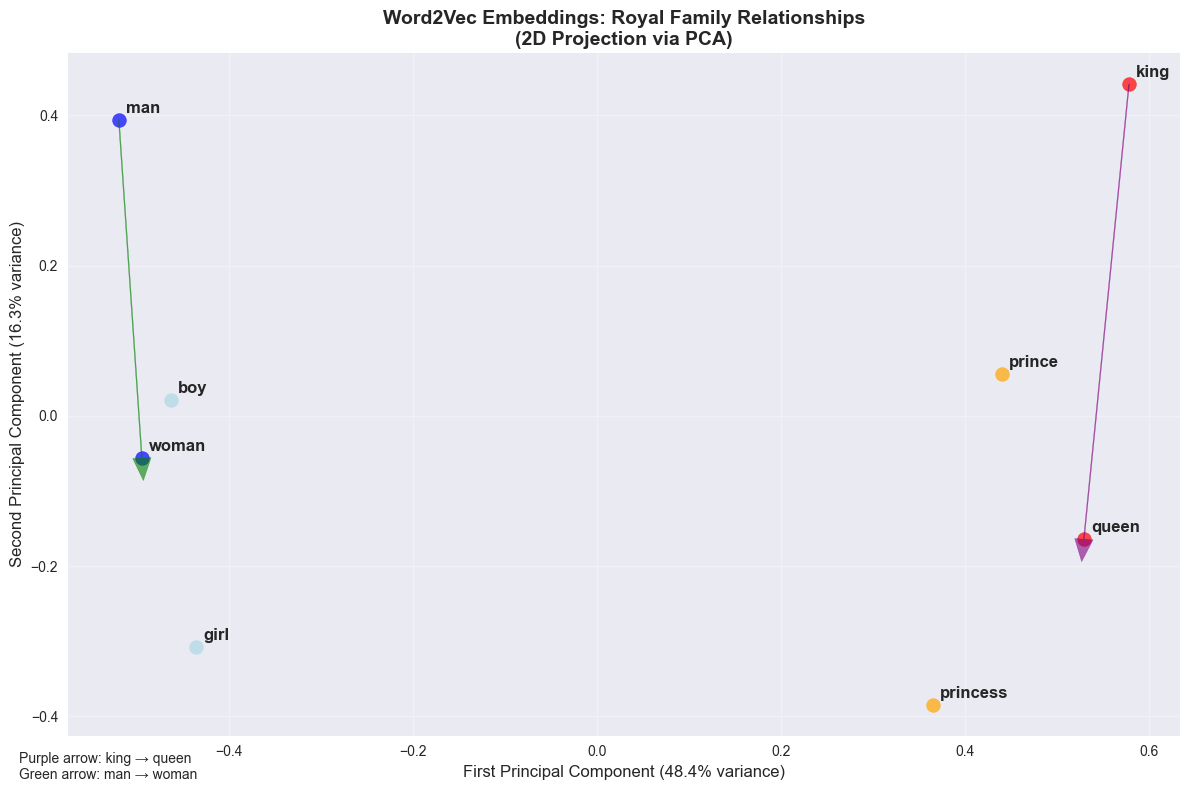


📊 PCA Analysis:
First 2 components explain 64.7% of the variance
Original vectors had 300 dimensions


In [6]:
# Collect words for our royal family visualization
royal_words = ['king', 'queen', 'prince', 'princess', 'man', 'woman', 'boy', 'girl']
royal_vectors = []
valid_words = []

for word in royal_words:
    vec = get_word_vector(word)
    if vec is not None:
        royal_vectors.append(vec)
        valid_words.append(word)

# Convert to numpy array for PCA
royal_matrix = np.array(royal_vectors)

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
royal_2d = pca.fit_transform(royal_matrix)

# Create the visualization
plt.figure(figsize=(12, 8))

# Plot each word
colors = ['red', 'red', 'orange', 'orange', 'blue', 'blue', 'lightblue', 'lightblue']
for i, word in enumerate(valid_words):
    plt.scatter(royal_2d[i, 0], royal_2d[i, 1], c=colors[i], s=100, alpha=0.7)
    plt.annotate(word, (royal_2d[i, 0], royal_2d[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=12, fontweight='bold')

# Draw arrows to show relationships
# Find indices for our main words
try:
    king_idx = valid_words.index('king')
    queen_idx = valid_words.index('queen')
    man_idx = valid_words.index('man')
    woman_idx = valid_words.index('woman')
    
    # Draw gender relationship arrows
    plt.arrow(royal_2d[king_idx, 0], royal_2d[king_idx, 1],
              royal_2d[queen_idx, 0] - royal_2d[king_idx, 0],
              royal_2d[queen_idx, 1] - royal_2d[king_idx, 1],
              head_width=0.02, head_length=0.03, fc='purple', ec='purple', alpha=0.6)
    
    plt.arrow(royal_2d[man_idx, 0], royal_2d[man_idx, 1],
              royal_2d[woman_idx, 0] - royal_2d[man_idx, 0],
              royal_2d[woman_idx, 1] - royal_2d[man_idx, 1],
              head_width=0.02, head_length=0.03, fc='green', ec='green', alpha=0.6)
except ValueError:
    print("Some words not found for arrow drawing")

plt.title('Word2Vec Embeddings: Royal Family Relationships\n(2D Projection via PCA)', fontsize=14, fontweight='bold')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add legend
plt.figtext(0.02, 0.02, 'Purple arrow: king → queen\nGreen arrow: man → woman', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n📊 PCA Analysis:")
print(f"First 2 components explain {sum(pca.explained_variance_ratio_):.1%} of the variance")
print(f"Original vectors had {royal_matrix.shape[1]} dimensions")

## Part 4: Word Similarity and Distance Metrics

Understanding how we measure word similarity is crucial for entity resolution. Let's explore different distance metrics and their implications.

In [7]:
def calculate_distances(word1, word2):
    """Calculate various distance metrics between two words."""
    vec1 = get_word_vector(word1)
    vec2 = get_word_vector(word2)
    
    if vec1 is None or vec2 is None:
        return None
    
    # Cosine similarity (most common for word embeddings)
    cosine_sim = cosine_similarity([vec1], [vec2])[0][0]
    
    # Euclidean distance
    euclidean_dist = np.linalg.norm(vec1 - vec2)
    
    # Dot product
    dot_product = np.dot(vec1, vec2)
    
    return {
        'cosine_similarity': cosine_sim,
        'euclidean_distance': euclidean_dist,
        'dot_product': dot_product
    }

# Test with various word pairs
word_pairs = [
    ('king', 'queen'),
    ('man', 'woman'),
    ('cat', 'dog'),
    ('car', 'vehicle'),
    ('book', 'library'),
    ('happy', 'sad'),
    ('king', 'car')  # Unrelated words
]

results = []
for word1, word2 in word_pairs:
    distances = calculate_distances(word1, word2)
    if distances:
        results.append({
            'Word 1': word1,
            'Word 2': word2,
            'Cosine Similarity': f"{distances['cosine_similarity']:.3f}",
            'Euclidean Distance': f"{distances['euclidean_distance']:.1f}",
            'Dot Product': f"{distances['dot_product']:.1f}"
        })

# Display as a formatted table
df = pd.DataFrame(results)
print("📏 Distance Metrics Between Word Pairs")
print("="*60)
print(df.to_string(index=False))

print("\n💡 Key Insights:")
print("• Cosine similarity ranges from -1 to 1 (higher = more similar)")
print("• Euclidean distance measures absolute difference (lower = more similar)")
print("• For word embeddings, cosine similarity is typically preferred")
print("• Notice how semantically related words have higher cosine similarities")

📏 Distance Metrics Between Word Pairs
Word 1  Word 2 Cosine Similarity Euclidean Distance Dot Product
  king   queen             0.651                0.8         0.7
   man   woman             0.766                0.7         0.8
   cat     dog             0.761                0.7         0.8
   car vehicle             0.782                0.7         0.8
  book library             0.325                1.2         0.3
 happy     sad             0.535                1.0         0.5
  king     car             0.062                1.4         0.1

💡 Key Insights:
• Cosine similarity ranges from -1 to 1 (higher = more similar)
• Euclidean distance measures absolute difference (lower = more similar)
• For word embeddings, cosine similarity is typically preferred
• Notice how semantically related words have higher cosine similarities


## Part 5: Application to Library Metadata

Now let's apply these concepts to the real challenge we face in library metadata: distinguishing between different people with similar names. We'll use your entity resolution examples.

In [8]:
# Library metadata examples from your entity resolution dataset
schubert_composer = {
    'name': 'Schubert, Franz, 1797-1828',
    'description': 'Austrian composer known for symphonies and chamber music',
    'context_words': ['composer', 'music', 'symphony', 'Austrian', 'classical', 'chamber']
}

schubert_artist = {
    'name': 'Schubert, Franz August, 1805-1893', 
    'description': 'German artist associated with archaeology and photography',
    'context_words': ['artist', 'German', 'archaeology', 'photography', 'visual', 'painter']
}

def analyze_context_similarity(person1, person2):
    """Compare two people based on their context words using Word2Vec."""
    print(f"🔍 Comparing: {person1['name']} vs {person2['name']}")
    print(f"Description 1: {person1['description']}")
    print(f"Description 2: {person2['description']}")
    print()
    
    # Get vectors for context words
    vectors1 = [get_word_vector(word) for word in person1['context_words']]
    vectors2 = [get_word_vector(word) for word in person2['context_words']]
    
    # Filter out None values
    vectors1 = [v for v in vectors1 if v is not None]
    vectors2 = [v for v in vectors2 if v is not None]
    
    if not vectors1 or not vectors2:
        print("⚠️ Could not get vectors for all words")
        return
    
    # Calculate average vector for each person (simple centroid approach)
    avg_vector1 = np.mean(vectors1, axis=0)
    avg_vector2 = np.mean(vectors2, axis=0)
    
    # Calculate similarity
    similarity = cosine_similarity([avg_vector1], [avg_vector2])[0][0]
    
    print(f"📊 Context Vector Similarity: {similarity:.3f}")
    
    # Individual word-to-word similarities
    print("\n🔗 Cross-context word similarities:")
    max_sim = 0
    max_pair = None
    
    for word1 in person1['context_words']:
        for word2 in person2['context_words']:
            distances = calculate_distances(word1, word2)
            if distances:
                sim = distances['cosine_similarity']
                if sim > max_sim:
                    max_sim = sim
                    max_pair = (word1, word2)
                print(f"  {word1} ↔ {word2}: {sim:.3f}")
    
    print(f"\n🎯 Highest individual word similarity: {max_pair[0]} ↔ {max_pair[1]} ({max_sim:.3f})")
    
    return similarity

# Analyze the Schubert disambiguation challenge
similarity = analyze_context_similarity(schubert_composer, schubert_artist)

print("\n" + "="*70)
print("💭 Analysis for Entity Resolution:")
print(f"• Context similarity of {similarity:.3f} suggests these are DIFFERENT people")
print("• The low similarity reflects their different professional domains")
print("• Classical music vs archaeology/photography contexts are semantically distant")
print("• This demonstrates how embeddings can help disambiguate similar names")

🔍 Comparing: Schubert, Franz, 1797-1828 vs Schubert, Franz August, 1805-1893
Description 1: Austrian composer known for symphonies and chamber music
Description 2: German artist associated with archaeology and photography

📊 Context Vector Similarity: 0.543

🔗 Cross-context word similarities:
  composer ↔ artist: 0.538
  composer ↔ German: 0.103
  composer ↔ archaeology: 0.161
  composer ↔ photography: 0.230
  composer ↔ visual: 0.241
  composer ↔ painter: 0.502
  music ↔ artist: 0.422
  music ↔ German: 0.077
  music ↔ archaeology: 0.148
  music ↔ photography: 0.364
  music ↔ visual: 0.272
  music ↔ painter: 0.224
  symphony ↔ artist: 0.256
  symphony ↔ German: 0.080
  symphony ↔ archaeology: 0.171
  symphony ↔ photography: 0.126
  symphony ↔ visual: 0.220
  symphony ↔ painter: 0.210
  Austrian ↔ artist: 0.039
  Austrian ↔ German: 0.742
  Austrian ↔ archaeology: 0.092
  Austrian ↔ photography: 0.037
  Austrian ↔ visual: 0.033
  Austrian ↔ painter: 0.117
  classical ↔ artist: 0.358
  cl

## Part 6: Modern Tokenization with tiktoken

While Word2Vec works with whole words, modern language models use **subword tokenization**. Let's explore how tiktoken (used by OpenAI's models) breaks text into tokens.

In [9]:
import tiktoken

# Initialize the tokenizer used by OpenAI's text-embedding-3-small model
encoding = tiktoken.get_encoding("cl100k_base")  # GPT-4 and embedding models use this

def analyze_tokenization(text):
    """Analyze how text gets tokenized."""
    tokens = encoding.encode(text)
    token_strings = [encoding.decode([token]) for token in tokens]
    
    print(f"📝 Original text: '{text}'")
    print(f"🔢 Number of tokens: {len(tokens)}")
    print(f"📋 Token breakdown:")
    
    for i, (token_id, token_str) in enumerate(zip(tokens, token_strings)):
        # Show special characters visually
        display_str = repr(token_str) if '\n' in token_str or '\t' in token_str else f"'{token_str}'"
        print(f"  {i+1:2d}. {display_str:15} (ID: {token_id})")
    
    return tokens, token_strings

# Test with various library metadata examples
test_texts = [
    "Schubert, Franz",
    "Archäologie und Photographie",  # German with special characters
    "Photography in archaeology",
    "Mainz: P. von Zabern, 1978",
    "ausgewählt von Franz Schubert"  # More German text
]

for text in test_texts:
    print("\n" + "="*60)
    tokens, token_strings = analyze_tokenization(text)
    
print("\n" + "="*60)
print("💡 Key Observations about Tokenization:")
print("• Subwords allow handling of rare words and multilingual text")
print("• Punctuation often gets separate tokens")
print("• Common words typically get single tokens")
print("• Special characters (ä, ü) may be tokenized differently")
print("• This is why modern models work better with diverse vocabulary")


📝 Original text: 'Schubert, Franz'
🔢 Number of tokens: 5
📋 Token breakdown:
   1. 'Sch'           (ID: 31224)
   2. 'ub'            (ID: 392)
   3. 'ert'           (ID: 531)
   4. ','             (ID: 11)
   5. ' Franz'        (ID: 66620)

📝 Original text: 'Archäologie und Photographie'
🔢 Number of tokens: 6
📋 Token breakdown:
   1. 'Arch'          (ID: 19249)
   2. 'ä'             (ID: 2357)
   3. 'ologie'        (ID: 38469)
   4. ' und'          (ID: 2073)
   5. ' Photograph'   (ID: 33255)
   6. 'ie'            (ID: 648)

📝 Original text: 'Photography in archaeology'
🔢 Number of tokens: 5
📋 Token breakdown:
   1. 'Phot'          (ID: 53304)
   2. 'ography'       (ID: 5814)
   3. ' in'           (ID: 304)
   4. ' archae'       (ID: 39211)
   5. 'ology'         (ID: 2508)

📝 Original text: 'Mainz: P. von Zabern, 1978'
🔢 Number of tokens: 13
📋 Token breakdown:
   1. 'Main'          (ID: 6334)
   2. 'z'             (ID: 89)
   3. ':'             (ID: 25)
   4. ' P'            (ID: 393)


## Part 7: Comparing Word2Vec vs Modern Approaches

Let's understand the evolution from Word2Vec to modern embeddings and why this matters for entity resolution.

In [10]:
# Create a comparison of different approaches
comparison_data = {
    'Aspect': [
        'Training Data',
        'Context Window',
        'Vocabulary Handling',
        'Multilingual Support',
        'Model Size',
        'Computational Cost',
        'Contextual Understanding',
        'Fine-tuning Capability'
    ],
    'Word2Vec (2013)': [
        'Google News (100B words)',
        'Fixed small window',
        'Fixed vocabulary only',
        'Limited',
        '~1.5GB',
        'Low inference cost',
        'Static word meaning',
        'No fine-tuning'
    ],
    'OpenAI text-embedding-3-small (2024)': [
        'Diverse web + curated data',
        'Long sequence (8192 tokens)',
        'Subword tokenization',
        'Excellent (100+ languages)',
        'Hosted service',
        'API-based ($0.02/1M tokens)',
        'Context-aware meaning',
        'Task-specific fine-tuning'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("🚀 Evolution of Text Embeddings")
print("="*80)
print(comparison_df.to_string(index=False))

# Cost analysis for your Yale Library catalog
print("\n💰 Cost Analysis for Yale Library Catalog:")
print("="*50)

# Sample metadata record for token estimation
sample_record = '''Title: Archäologie und Photographie: fünfzig Beispiele zur Geschichte und Methode
Subjects: Photography in archaeology
Provision information: Mainz: P. von Zabern, 1978'''

tokens, _ = analyze_tokenization(sample_record)
tokens_per_record = len(tokens)

catalog_size = 17_590_104  # Your actual catalog size
estimated_total_tokens = catalog_size * tokens_per_record
cost_per_million = 0.02  # OpenAI pricing
estimated_cost = (estimated_total_tokens / 1_000_000) * cost_per_million

print(f"Sample record tokens: {tokens_per_record}")
print(f"Total catalog records: {catalog_size:,}")
print(f"Estimated total tokens: {estimated_total_tokens:,}")
print(f"Estimated embedding cost: ${estimated_cost:.2f}")
print(f"\n🎯 Embedding your entire catalog would cost approximately ${estimated_cost:.2f}")
print("This demonstrates the cost-effectiveness of modern embedding APIs!")

🚀 Evolution of Text Embeddings
                  Aspect          Word2Vec (2013) OpenAI text-embedding-3-small (2024)
           Training Data Google News (100B words)           Diverse web + curated data
          Context Window       Fixed small window          Long sequence (8192 tokens)
     Vocabulary Handling    Fixed vocabulary only                 Subword tokenization
    Multilingual Support                  Limited           Excellent (100+ languages)
              Model Size                   ~1.5GB                       Hosted service
      Computational Cost       Low inference cost          API-based ($0.02/1M tokens)
Contextual Understanding      Static word meaning                Context-aware meaning
  Fine-tuning Capability           No fine-tuning            Task-specific fine-tuning

💰 Cost Analysis for Yale Library Catalog:
📝 Original text: 'Title: Archäologie und Photographie: fünfzig Beispiele zur Geschichte und Methode
Subjects: Photography in archaeology
Provis

## Part 8: Hands-on Exercise - Entity Resolution Challenge

Now let's put everything together with a practical exercise using your actual entity resolution challenge.

In [11]:
# Create a mini entity resolution dataset
entities = [
    {
        'identity': '9.1',
        'person': 'Schubert, Franz',
        'title': 'Archäologie und Photographie: fünfzig Beispiele zur Geschichte und Methode',
        'subjects': 'Photography in archaeology',
        'composite': 'Schubert, Franz Archäologie und Photographie Photography in archaeology',
        'actual_person': 'Franz August Schubert (1805-1893, German artist)'
    },
    {
        'identity': '12.7', 
        'person': 'Schubert, Franz',
        'title': 'Symphony No. 8 in B minor "Unfinished"',
        'subjects': 'Symphonies Classical music',
        'composite': 'Schubert, Franz Symphony Classical music Austrian composer',
        'actual_person': 'Franz Schubert (1797-1828, Austrian composer)'
    },
    {
        'identity': '15.3',
        'person': 'Schubert, Franz',
        'title': 'Die schöne Müllerin',
        'subjects': 'Songs Lieder German poetry',
        'composite': 'Schubert, Franz Lieder Songs German poetry Austrian',
        'actual_person': 'Franz Schubert (1797-1828, Austrian composer)'
    }
]

def embedding_based_similarity(text1, text2):
    """Simple embedding similarity using Word2Vec word averaging."""
    # Tokenize and clean
    words1 = [w.lower() for w in text1.replace(',', ' ').split() if len(w) > 2]
    words2 = [w.lower() for w in text2.replace(',', ' ').split() if len(w) > 2]
    
    # Get vectors
    vectors1 = [get_word_vector(word) for word in words1]
    vectors2 = [get_word_vector(word) for word in words2]
    
    # Filter valid vectors
    vectors1 = [v for v in vectors1 if v is not None]
    vectors2 = [v for v in vectors2 if v is not None]
    
    if not vectors1 or not vectors2:
        return 0.0
    
    # Average vectors
    avg1 = np.mean(vectors1, axis=0)
    avg2 = np.mean(vectors2, axis=0)
    
    return cosine_similarity([avg1], [avg2])[0][0]

# Perform pairwise similarity analysis
print("🔍 Entity Resolution Analysis")
print("="*70)

results = []
for i in range(len(entities)):
    for j in range(i+1, len(entities)):
        entity1 = entities[i]
        entity2 = entities[j]
        
        # Calculate similarities for different fields
        name_sim = embedding_based_similarity(entity1['person'], entity2['person'])
        title_sim = embedding_based_similarity(entity1['title'], entity2['title'])
        subject_sim = embedding_based_similarity(entity1['subjects'], entity2['subjects'])
        composite_sim = embedding_based_similarity(entity1['composite'], entity2['composite'])
        
        # Determine if they're the same person
        same_person = 'Austrian composer' in entity1['actual_person'] and 'Austrian composer' in entity2['actual_person']
        
        results.append({
            'Entity 1': entity1['identity'],
            'Entity 2': entity2['identity'],
            'Name Similarity': f"{name_sim:.3f}",
            'Title Similarity': f"{title_sim:.3f}",
            'Subject Similarity': f"{subject_sim:.3f}", 
            'Composite Similarity': f"{composite_sim:.3f}",
            'Same Person?': 'YES' if same_person else 'NO'
        })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

print("\n💡 Key Insights:")
print("• Name similarity alone is insufficient (all pairs have 'Schubert, Franz')")
print("• Subject/context similarity is crucial for disambiguation")
print("• Composite fields that combine multiple signals work best")
print("• Real entity resolution needs multiple features + machine learning")

🔍 Entity Resolution Analysis
Entity 1 Entity 2 Name Similarity Title Similarity Subject Similarity Composite Similarity Same Person?
     9.1     12.7           1.000            0.493              0.363                0.674           NO
     9.1     15.3           1.000            0.774              0.460                0.767           NO
    12.7     15.3           1.000            0.441              0.710                0.845          YES

💡 Key Insights:
• Name similarity alone is insufficient (all pairs have 'Schubert, Franz')
• Subject/context similarity is crucial for disambiguation
• Composite fields that combine multiple signals work best
• Real entity resolution needs multiple features + machine learning


## Summary and Next Steps

🎓 **What We've Learned:**

1. **Word Embeddings Fundamentals**: Words become vectors that capture semantic meaning
2. **Mathematical Relationships**: Semantic relationships become vector arithmetic (king - man + woman ≈ queen)
3. **Distance Metrics**: Cosine similarity is typically best for text embeddings
4. **Tokenization Evolution**: From whole words (Word2Vec) to subwords (modern models)
5. **Real-world Application**: How embeddings help with entity resolution in library catalogs

🔜 **Next in Our Workshop Series:**

- **Weaviate Vector Database**: Efficient storage and similarity search for large-scale embeddings
- **Modern Embeddings**: OpenAI's text-embedding-3-small for production systems  
- **Classification with SetFit**: Fine-tuning embeddings for domain-specific tasks
- **Production Deployment**: Building scalable entity resolution pipelines

🎯 **Key Takeaway for Entity Resolution:**

The evolution from Word2Vec to modern embeddings represents a fundamental shift in how we can approach metadata challenges. Where traditional string matching fails, embedding-based approaches excel at capturing semantic meaning and context - essential for disambiguating complex bibliographic records.

---
*This notebook demonstrates foundational concepts for the Yale AI Research Techniques Workshop on Text Embeddings and Classification.*